# Agregación de datos y operaciones de grupo

Categorizar un conjunto de datos y aplicar una función a cada grupo, ya sea una agregación o transformación, es a menudo un componente crítico de un flujo de trabajo de análisis de datos. Pandas proporciona un
interfaz de grupo flexible, que le permite dividir, fragmentar y resumir conjuntos de datos en una manera natural


*   Dividir un objeto pandas en pedazos usando una o más llaves (en forma de funciones, arrays o nombres de columna de DataFrame)
*   Calcular estadísticas de resumen de grupo, como recuento, media o desviación estándar, o una función definida por el usuario

In [1]:
import numpy as np
import pandas as pd
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)
# DIR = "./data/"
DIR = "https://raw.githubusercontent.com/wesm/pydata-book/2nd-edition/examples/"

## GroupBy y sus mecánicas

Las tareas de agregacion con groupBy las podemos dividir en 3 pasos  


*   Dividir: Partir los datos en grupos basados en una o mas llaves.
*   Aplicar: A cada grupo aplicar una funcion que resulte en un nuevo valor.
*   Combinar: Juntar los resultados de las operaciones anteriores en un nuevo objeto resultado.



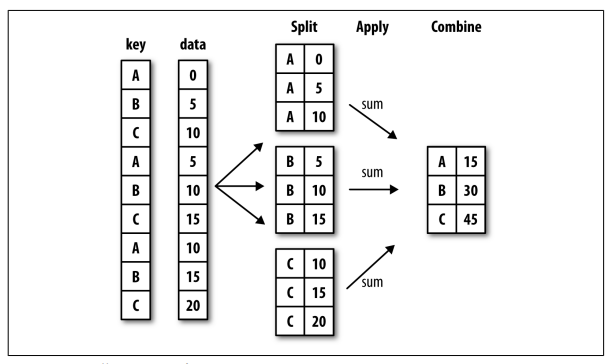

In [2]:
df = pd.DataFrame({'llave_1' : ['a', 'a', 'b', 'b', 'a'],
                   'llave_2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})
df

,llave_1,llave_2,data1,data2
0,a,one,-0.204708,1.393406
1,a,two,0.478943,0.092908
2,b,one,-0.519439,0.281746
3,b,two,-0.555730,0.769023
4,a,one,1.965781,1.246435


In [3]:
# El resultado de un groupby es un objeto GroupBy y no un DataFrame / Serie
grouped = df['data1'].groupby(df['llave_1'])
grouped

In [4]:
# Si aplicamos alguna funcion de agregacion a un objeto groupBy se aplicara a 
# cada grupo definido por las llaves pasadas a la funcion groupBy
grouped.mean()

llave_1
a    0.746672
b   -0.537585
Name: data1, dtype: float64

In [5]:
# Se puede pasar multiples llaves
means = df['data1'].groupby([df['llave_1'], df['llave_2']]).mean()
means

llave_1  llave_2
a        one        0.880536
         two        0.478943
b        one       -0.519439
         two       -0.555730
Name: data1, dtype: float64

In [6]:
# Unstack nos permite convertir la serie con dos niveles de indices en un 
# dataframe
means.unstack()

llave_2,one,two
llave_1,,
a,0.880536,0.478943
b,-0.519439,-0.555730


In [7]:
# En este ejemplo agregamos columnas y agrupamos por ellas
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df_1 = df.copy()
df_1['estado'] = states
df_1['periodo'] = years
df_1[['estado', 'periodo', 'data1']]

,estado,periodo,data1
0,Ohio,2005,-0.204708
1,California,2005,0.478943
2,California,2006,-0.519439
3,Ohio,2005,-0.555730
4,Ohio,2006,1.965781


In [8]:
df_1.groupby(['estado', 'periodo']).mean()['data1']

estado      periodo
California  2005       0.478943
            2006      -0.519439
Ohio        2005      -0.380219
            2006       1.965781
Name: data1, dtype: float64

In [9]:
# Alternativamente, podemos pasar los arrays de llaves deseadas y groupby
# las usara si son del tamano correcto
df['data1'].groupby([states, years]).mean()

California  2005    0.478943
            2006   -0.519439
Ohio        2005   -0.380219
            2006    1.965781
Name: data1, dtype: float64

In [10]:
# Si la informacion de las llaves esta contenida en el df, se puede usar el 
# nombre de la columna para agrupar
df.groupby('llave_1').mean()

,data1,data2
llave_1,,
a,0.746672,0.910916
b,-0.537585,0.525384


In [11]:
# Tambien se puede hacer con multiples columnas
df.groupby(['llave_1', 'llave_2']).mean()

data1     data2
llave_1 llave_2                    
a       one      0.880536  1.319920
        two      0.478943  0.092908
b       one     -0.519439  0.281746
        two     -0.555730  0.769023

### Iterando sobre grupos

El objeto groupby acepta la iteracion, genera una secuencia de duplas conteniendo el nombre del grupo y el pedazo de datos que le corresponde

In [12]:
for name, group in df.groupby('llave_1'):
    print("#"*80)
    print("Nombre del grupo: " + name)
    print(group)

################################################################################
Nombre del grupo: a
  llave_1 llave_2     data1     data2
0       a     one -0.204708  1.393406
1       a     two  0.478943  0.092908
4       a     one  1.965781  1.246435
################################################################################
Nombre del grupo: b
  llave_1 llave_2     data1     data2
2       b     one -0.519439  0.281746
3       b     two -0.555730  0.769023


In [13]:
# En el caso multillave, el primer elemento sera una tupla con los nombres de
# las llaves
for (k1, k2), group in df.groupby(['llave_1', 'llave_2']):
    print("#"*80)
    print("Nombre de los grupos: " + str((k1, k2)))
    print(group)

################################################################################
Nombre de los grupos: ('a', 'one')
  llave_1 llave_2     data1     data2
0       a     one -0.204708  1.393406
4       a     one  1.965781  1.246435
################################################################################
Nombre de los grupos: ('a', 'two')
  llave_1 llave_2     data1     data2
1       a     two  0.478943  0.092908
################################################################################
Nombre de los grupos: ('b', 'one')
  llave_1 llave_2     data1     data2
2       b     one -0.519439  0.281746
################################################################################
Nombre de los grupos: ('b', 'two')
  llave_1 llave_2    data1     data2
3       b     two -0.55573  0.769023


In [14]:
# Podemos usar esto para hacer un diccionario con los grupos de datos!
pieces = dict(list(df.groupby('llave_1')))
pieces['b']

,llave_1,llave_2,data1,data2
2,b,one,-0.519439,0.281746
3,b,two,-0.555730,0.769023


In [15]:
# Podemos agrupar a traves de las columnas tambien
print(df.dtypes)
grouped = df.groupby(df.dtypes, axis=1)

llave_1     object
llave_2     object
data1      float64
data2      float64
dtype: object


In [16]:
for dtype, group in grouped:
    print("#"*80)
    print("Tipo de dato: " + str(dtype))
    print(group)

################################################################################
Tipo de dato: float64
      data1     data2
0 -0.204708  1.393406
1  0.478943  0.092908
2 -0.519439  0.281746
3 -0.555730  0.769023
4  1.965781  1.246435
################################################################################
Tipo de dato: object
  llave_1 llave_2
0       a     one
1       a     two
2       b     one
3       b     two
4       a     one


### Seleccionando un subconjunto de columnas

Es posible seleccionar la columna a ser agregada por medio de indexacion despues de hacer el groupby.  
Esto es especialmente util a la hora de tratar con dataframes grandes  

In [17]:
df.groupby(['llave_1', 'llave_2'])[['data2']].mean()

data2
llave_1 llave_2          
a       one      1.319920
        two      0.092908
b       one      0.281746
        two      0.769023

In [18]:
s_grouped = df.groupby(['llave_1', 'llave_2'])['data2']
s_grouped
s_grouped.mean()

llave_1  llave_2
a        one        1.319920
         two        0.092908
b        one        0.281746
         two        0.769023
Name: data2, dtype: float64

### Agrupando con diccionarios y series

In [19]:
people = pd.DataFrame(np.random.randn(5, 5),
                      columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people.iloc[2:3, [1, 2]] = np.nan # Add a few NA values
people

,a,b,c,d,e
Joe,1.007189,-1.296221,0.274992,0.228913,1.352917
Steve,0.886429,-2.001637,-0.371843,1.669025,-0.438570
Wes,-0.539741,NaN,NaN,-1.021228,-0.577087
Jim,0.124121,0.302614,0.523772,0.000940,1.343810
Travis,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


Si tenemos un diccionario que mapee cierta correspondencia entre algun grupo y los indices de algun eje, es posible agrupar por dicho diccionario.

In [20]:
mapping = {'a': 'rojo', 'b': 'rojo', 'c': 'azul',
           'd': 'azul', 'e': 'rojo', 'f' : 'naranja'}

In [21]:
# Nota que f no esta en las columnas y eso no causa un error
by_column = people.groupby(mapping, axis=1)
by_column.sum()

,azul,rojo
Joe,0.503905,1.063885
Steve,1.297183,-1.553778
Wes,-1.021228,-1.116829
Jim,0.524712,1.770545
Travis,-4.230992,-2.405455


In [22]:
# Hemos mencionado antes la similitud entre las series y los diccionarios. En 
# este ejemplo podemos hacer un mapeo con una serie y esto funciona de manera perfecta
map_series = pd.Series(mapping)
print(map_series)
people.groupby(map_series, axis=1).count()

a       rojo
b       rojo
c       azul
d       azul
e       rojo
f    naranja
dtype: object


,azul,rojo
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


### Agrupando con funciones

Una generalizacion de lo anterior es la agrupacion por funciones.  
En el ejemplo siguiente agruparemos los nombres usados en el indice por el numero de letras que contienen usando la funcion `len`.

In [23]:
[(p, len(p)) for p in people.index]

[('Joe', 3), ('Steve', 5), ('Wes', 3), ('Jim', 3), ('Travis', 6)]

In [24]:
people.groupby(len).sum()

,a,b,c,d,e
3,0.591569,-0.993608,0.798764,-0.791374,2.119639
5,0.886429,-2.001637,-0.371843,1.669025,-0.438570
6,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


Se puede combinar el agrupado por funciion con otro tipo de agrupados

In [25]:
key_list = ['uno', 'uno', 'uno', 'dos', 'dos']
people.groupby([len, key_list]).min()

a         b         c         d         e
3 dos  0.124121  0.302614  0.523772  0.000940  1.343810
  uno -0.539741 -1.296221  0.274992 -1.021228 -0.577087
5 uno  0.886429 -2.001637 -0.371843  1.669025 -0.438570
6 dos -0.713544 -0.831154 -2.370232 -1.860761 -0.860757

### Agrupando por niveles de un multiindice

In [26]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                    [1, 3, 5, 1, 3]],
                                    names=['cty', 'tenor'])
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      0.560145 -1.265934  0.119827 -1.063512  0.332883
1     -2.359419 -0.199543 -1.541996 -0.970736 -1.307030
2      0.286350  0.377984 -0.753887  0.331286  1.349742
3      0.069877  0.246674 -0.011862  1.004812  1.327195

Si tenemos un DataFrame multiindice, podemos agrupar por alguno de los niveles

In [27]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


## Data Aggregation

Las siguientes funciones cuentan con optimizaciones para usarse con el agrupamiento de DataFrames

| Funcion       | Descripcion      |
|-------------|---------------------------------------------|
| count       | Numero de valores no nulos en el grupo      |
| sum         | Suma de valores no nulos                    |
| mean        | Media de valores no nulos                   |
| median      | mediana de valores no nulos                 |
| std, var    | Varianza y desviacion estandar insesgados   |
| min, max    | Maximo y minimo de valores no nulos         |
| prod        | Producto de valores no nulos                |
| first, last | Primer y ultimo valor (por filas) no nulos  |

Pero como tal podemos usar cualquier funcion o metodo que realice una agregacion de un array (o lista, o serie) a un valor unico (escalar)

In [28]:
df
grouped = df.groupby('llave_1')
grouped['data1'].quantile(0.9)

llave_1
a    1.668413
b   -0.523068
Name: data1, dtype: float64

Tambien podemos hacer nuestras propias funciones, siempre y cuando cumplan que tomen como argumento un array y regresen un escalar.

In [29]:
def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped.agg(peak_to_peak)

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


,data1,data2
llave_1,,
a,2.170488,1.300498
b,0.036292,0.487276


In [30]:
def iqr(arr):
  return arr.quantile(.75) - arr.quantile(.25)
grouped.agg(iqr)

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


,data1,data2
llave_1,,
a,1.085244,0.650249
b,0.018146,0.243638


Como tal, toda funcion de agregacion que sirva a una serie/dataframe, podra ser usada dentro de un proceso `.groupby().agg()`

| Metodo | Descripción |
| ----------- | ----------- |
|`.count()`| Número de valores que no son NA|
|`.describe()`| Calcular conjunto de estadísticas de resumen para Series o cada columna de DataFrame|
|`.min()`, `.max()` | Calcular valores mínimos y máximos
|`.argmin()`, `.argmax()` | Calcular ubicaciones de índice (enteros) en las que se obtuvo el valor mínimo o máximo, respectivamente
|`.idxmin()`, `.idxmax()` | Calcule las etiquetas de índice en las que se obtuvo el valor mínimo o máximo, respectivamente
|`.quantile()` | Calcule el cuantil de muestra que va de 0 a 1
|`.sum()` | Suma de valores
|`.mean()` | Media de los valores
|`.median()`| Mediana aritmética (50% cuantil) de valores
|`.mad()` | Desviación absoluta media del valor medio
|`.prod()`| Producto de todos los valores
|`.var()`| Varianza muestral de los valores
|`.std()`| Desviación estándar de la muestra de los valores
|`.skew()` | asimetría de la muestra (tercer momento) de los valores
|`.kurt()` | Ejemplo de curtosis (cuarto momento) de valores
|`.cumsum()`| Suma acumulada de valores
|`.cummin()` , `.cummax()`| Mínimo o máximo acumulativo de valores, respectivamente
|`.cumprod()`| Producto acumulado de valores
|`.diff()`| Calcular la primera diferencia aritmética (útil para series de tiempo)
|`.pct_change()`| Calcular cambios porcentuales

Esto incluye el caso especial de `.describe()` que no regresa un escalar, pero puede ser usado con ob

In [31]:
grouped.describe()

data1                                                              \
        count      mean       std       min       25%       50%       75%   
llave_1                                                                     
a         3.0  0.746672  1.109736 -0.204708  0.137118  0.478943  1.222362   
b         2.0 -0.537585  0.025662 -0.555730 -0.546657 -0.537585 -0.528512   

                  data2                                                    \
              max count      mean       std       min       25%       50%   
llave_1                                                                     
a        1.965781   3.0  0.910916  0.712217  0.092908  0.669671  1.246435   
b       -0.519439   2.0  0.525384  0.344556  0.281746  0.403565  0.525384   

                             
              75%       max  
llave_1                      
a        1.319920  1.393406  
b        0.647203  0.769023

### Agregacion columna a columna y a multiples columnas

Considieremos este dataset con informacion de propinas 

In [32]:
tips = pd.read_csv(DIR + 'tips.csv')
# Calcula el porcentaje de propina
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips[:6]

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
5,25.29,4.71,No,Sun,Dinner,4,0.186240


In [33]:
grouped = tips.groupby(['day', 'smoker'])

In [34]:
grouped_pct = grouped['tip_pct']
grouped_pct.agg('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

Si queremos obtener mas de una agregacion, es posible pasar el nombre de los metodos o las funciones correspondientes detro de una lista

In [35]:
grouped_pct.agg(['mean', 'std', peak_to_peak])

mean       std  peak_to_peak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

Si queremos modificar el nombre de las columnas, es posible hacerlo pasando los metodos en duplas `[("nombre metodo 1", <metodo1>), ("nombre metodo 2", <metodo2>)]`

In [36]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

El aplicar multiples funciones de agregacion a multiples columnas nos regresa un DataFrame con columnas jerarquicas 

In [37]:
functions = ['count', 'mean', 'max']
result = grouped['tip_pct', 'total_bill'].agg(functions)
result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

In [38]:
result['tip_pct']

count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255

In [39]:
result['total_bill']

count       mean    max
day  smoker                         
Fri  No          4  18.420000  22.75
     Yes        15  16.813333  40.17
Sat  No         45  19.661778  48.33
     Yes        42  21.276667  50.81
Sun  No         57  20.506667  48.17
     Yes        19  24.120000  45.35
Thur No         45  17.113111  41.19
     Yes        17  19.190588  43.11

In [40]:
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]
grouped['tip_pct', 'total_bill'].agg(ftuples)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


tip_pct              total_bill            
            Durchschnitt Abweichung Durchschnitt  Abweichung
day  smoker                                                 
Fri  No         0.151650   0.000791    18.420000   25.596333
     Yes        0.174783   0.002631    16.813333   82.562438
Sat  No         0.158048   0.001581    19.661778   79.908965
     Yes        0.147906   0.003767    21.276667  101.387535
Sun  No         0.160113   0.001793    20.506667   66.099980
     Yes        0.187250   0.023757    24.120000  109.046044
Thur No         0.160298   0.001503    17.113111   59.625081
     Yes        0.163863   0.001551    19.190588   69.808518

Si queremos pasar distintos metodos a distintas columnas, esto lo podemos hacer por medio de diccionarios

In [43]:
grouped.agg({'tip' : np.max, 'size' : 'sum'})


tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [44]:
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'],
             'size' : 'sum'})

tip_pct                               size
                  min       max      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

Tambien es posible hacer que el DataFrame resultado no ponga las columnas de agrupación como indice

In [42]:
tips.groupby(['day', 'smoker'], as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863
